### imports

In [1]:
# pip install pymonntorch

In [2]:
# pip install cnrl-conex

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import tensorflow as tf
from skimage.transform import resize
from skimage.color import rgb2gray
from scipy import ndimage


import math
import cv2
from PIL import Image
import torch.nn.functional as F


from pymonntorch import (
      NeuronDimension,
      Behavior, 
      Network, 
      Recorder,
      EventRecorder,
      NeuronGroup,
      SynapseGroup
)

from conex.behaviors.neurons import (
    SimpleDendriteStructure,
    SimpleDendriteComputation,
    SpikeTrace,
    NeuronAxon,
    LIF,
    Fire,
    KWTA,
    VoltageBaseHomeostasis,
    ActivityBaseHomeostasis,
)
from conex.behaviors.synapses import (
    SynapseInit,
    WeightInitializer,
    WeightClip,
    SimpleDendriticInput,
    Conv2dDendriticInput,
    AveragePool2D,
    BaseDendriticInput,
    LateralDendriticInput,
    SimpleSTDP,
    Conv2dSTDP,
    Local2dSTDP,
    CurrentNormalization,
    BaseLearning
)

from conex.helpers.filters import (
    DoGFilter,
    GaborFilter
)

from conex.helpers.transforms import (
    Conv2dFilter,
    AbsoluteTransform,
    Poisson,
    Intensity2Latency
)

### params

In [4]:
# Network peoperties
DEVICE = "cpu"
DTYPE = torch.float32
DT = 1

# LIF
RES = 5.0
THR = -50.
TAU = 10.
V_RESET = -75.
V_REST = -67.
TRACE_TAU = 10.

# Voltage-Based Homeostasis
TARGET_V = THR
MAX_TA = THR+30
MIN_TA = THR-30
ETA = 0.0008

ITER = 25
TW = 25
RW = 25
INP_SIZE = 28
N_FEATURES = 6
KERNEL_SIZE = 5


### plots

In [5]:
def showImage(img):
    plt.figure(figsize=(3,3))
    print(f'Image Shape: {img.shape} - Max Pixel Value: {img.max()} -  Min Pixel Value: {img.min()}')
    img_sq = img.squeeze(0).squeeze(0)
    plt.imshow(img_sq, cmap='gray')
    plt.axis('off')
    plt.show()
    return

def scaleImage(img, mn=0., mx=255.):
    image = img.clone()
    image_normalized = (image - image.min()) / (image.max() - image.min())
    image_scaled = image_normalized * (mx - mn) + mn
    return image_scaled

def rasterPlot(spikes, tw):
    plt.figure(figsize=(12,4))
    plt.scatter(torch.nonzero(spikes, as_tuple=True)[0], torch.nonzero(spikes, as_tuple=True)[1], s=2)
    plt.xlabel("Time")
    plt.ylabel("Neurons")
    plt.title('Raster Plot')
    plt.xlim(-1, tw)
    plt.show()

### NG Input

In [6]:
class NoiseCurrent(Behavior):
    def initialize(self,ng):
        self.value = self.parameter('value', None)
        self.limit = self.parameter('limit', 1)
        self.rate = self.parameter('rate', 0.5)
        ng.I = ng.vector(mode=self.value)
    
    def forward(self, ng):
        rnd = round(np.random.normal(0, 1)) * self.limit
        if not torch.any(ng.I + rnd < 0):
            ng.I += rnd


### WATERLOO

In [7]:
# image_tensor = Xx[0].unsqueeze(0).unsqueeze(0)
# dog_on = DoGFilter(size=5, sigma_1=1, sigma_2=2, dtype=torch.float32, zero_mean=True).clone().detach().unsqueeze(0).unsqueeze(0)
# convFilter_on = Conv2dFilter(filters=dog_on, padding='same')
# print(image_conv_on.max(), image_conv_on.min())
# image_conv_on = convFilter_on(input=image_tensor)
    
# dog_off = DoGFilter(size=5, sigma_1=2, sigma_2=1, dtype=torch.float32,zero_mean=True).clone().detach().unsqueeze(0).unsqueeze(0)
# convFilter_off = Conv2dFilter(filters=dog_off, padding='same')
# image_conv_off = convFilter_off(input=image_tensor)
# print(image_conv_off.max(), image_conv_off.min())

# # Assuming you have separate ON-center and OFF-center response tensors
# ttfs = TimeToFirstSpike(image_conv_on, image_conv_off, TW, threshold=0.1)

# # Encode spikes
# spikes_flattened, on_spikes, off_spikes, combined_spikes = ttfs.encode()

# print(f"ON spikes shape: {on_spikes.shape}")
# print(f"OFF spikes shape: {off_spikes.shape}")
# print(f"Combined spikes shape: {combined_spikes.shape}")
# print(f"Flattened spikes shape: {spikes_flattened.shape}")

# # Visualize activation histograms
# ttfs.plot_activation_histograms()

# # Visualize raster plots
# ttfs.plot_raster_plots()

# # If you want to adjust the threshold
# ttfs.set_threshold(0.2)
# # Re-encode with new threshold
# spikes_flattened, on_spikes, off_spikes, combined_spikes = ttfs.encode()


In [8]:
class TimeToFirstSpike2():
    def __init__(self, img, time_window):
        self.img = img.clone().squeeze(0).squeeze(0)
        self.time_window = time_window

    def encode(self):
        spike_times = abs(self.img - self.img.max()) * (self.time_window - 1) // self.img.max()
        spikes = torch.Tensor(self.time_window, *self.img.size(), device="cpu")
        
        for time in range(self.time_window-1):
            spikes[time] = spike_times == time
        return spikes.view(TW, -1), spikes.squeeze(2).squeeze(1)
    

In [9]:
def prepareThisInput(img):
    image_tensor = img.unsqueeze(0).unsqueeze(0)
    
    dog_on = DoGFilter(size=3, sigma_1=2, sigma_2=1, dtype=torch.float32).clone().detach().unsqueeze(0).unsqueeze(0)
    convFilter_on = Conv2dFilter(filters=dog_on, padding='same')
    image_conv_on = convFilter_on(input=image_tensor)
#     spikes_flatten_on, spikes_2d_on = TimeToFirstSpike2(image_conv_on, TW).encode()
    i2l = Intensity2Latency(time_window=TW, min_val=image_conv_on.min().item(), max_val=image_conv_on.max().item(), sparsity=0.5)
    spikes_on_2d = i2l(image_conv_on).squeeze(2)
    
    dog_off = DoGFilter(size=3, sigma_1=1, sigma_2=2, dtype=torch.float32).clone().detach().unsqueeze(0).unsqueeze(0)
    convFilter_off = Conv2dFilter(filters=dog_off, padding='same')
    image_conv_off = convFilter_off(input=image_tensor)
#     spikes_flatten_off, spikes_2d_off = TimeToFirstSpike2(image_conv_off, TW).encode()
    i2l = Intensity2Latency(time_window=TW, min_val=image_conv_off.min().item(), max_val=image_conv_off.max().item(), sparsity=0.5)
    spikes_off_2d = i2l(image_conv_off).squeeze(2)
    
#     showImage(image_tensor)
#     showImage(dog_on)
#     showImage(image_conv_on)
#     rasterPlot(spikes_on_2d.view(TW, -1), TW)    
    
#     showImage(dog_off)
#     showImage(image_conv_off)
#     rasterPlot(spikes_off_2d.view(TW, -1), TW)    

    # Combine responses by stacking
    spikes_2d_combined = torch.stack([spikes_on_2d, spikes_off_2d], dim=1)
    spikes_flatten_combined = torch.stack([spikes_on_2d.view(TW, -1), spikes_off_2d.view(TW, -1)], dim=1)
    print(spikes_on_2d.shape)
    return spikes_off_2d.view(TW,1, -1), spikes_off_2d

def prepWithoutDOG(img):
    image_tensor = img.unsqueeze(0).unsqueeze(0)
    spikes_flatten_off, spikes_2d_off = TimeToFirstSpike(image_tensor, TW).encode()
#     showImage(image_tensor)
#     rasterPlot(spikes_flatten_off, TW)    
    return spikes_flatten_off, spikes_2d_off

In [10]:
import os 
path = '/kaggle/input/cnrl-waterloo-dataset'

# X_train = np.array([np.array(Image.open(f'{path}/{img}').convert('L').resize((INP_SIZE, INP_SIZE))) for img in os.listdir(path)])
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
# X_resized_gray = np.array([
#     rgb2gray(resize(img, (INP_SIZE, INP_SIZE), anti_aliasing=True))
#     for img in X_train[:50]
# ])
X_res = np.array([resize(img, (INP_SIZE, INP_SIZE), anti_aliasing=True) for img in X_train[:500]])
Xx = torch.tensor(X_res, dtype=torch.float32)

input_spikes = torch.Tensor()
input_spikes_2d = torch.Tensor()
reset_2d = torch.zeros(RW,1, INP_SIZE, INP_SIZE)
reset_flat = torch.zeros(RW,1,INP_SIZE * INP_SIZE)

for i in range(1):
    for digit in Xx[:10]:
        spikes_flatten, spikes_2d = prepareThisInput(digit)
        input_spikes = torch.cat((input_spikes, reset_flat))
        input_spikes = torch.cat((input_spikes, spikes_flatten))
        input_spikes_2d = torch.cat((input_spikes_2d, reset_2d))    
        input_spikes_2d = torch.cat((input_spikes_2d, spikes_2d))    

print(input_spikes.shape)
print(input_spikes_2d.shape)
ITER = input_spikes.shape[0]
ITER

torch.Size([25, 1, 28, 28])
torch.Size([25, 1, 28, 28])
torch.Size([25, 1, 28, 28])
torch.Size([25, 1, 28, 28])
torch.Size([25, 1, 28, 28])
torch.Size([25, 1, 28, 28])
torch.Size([25, 1, 28, 28])
torch.Size([25, 1, 28, 28])
torch.Size([25, 1, 28, 28])
torch.Size([25, 1, 28, 28])
torch.Size([500, 1, 784])
torch.Size([500, 1, 28, 28])


500

In [11]:
print(input_spikes_2d.unsqueeze(2).shape)


torch.Size([500, 1, 1, 28, 28])


### CIFAR

In [12]:
# (X_train, _), (_, _) = tf.keras.datasets.cifar100.load_data()
# X_resized_gray = np.array([
#     rgb2gray(resize(img, (INP_SIZE, INP_SIZE), anti_aliasing=True))
#     for img in X_train[:300]
# ])

# Xx = torch.tensor(X_resized_gray, dtype=torch.float32)
# input_spikes = torch.Tensor()
# input_spikes_2d = torch.Tensor()

# for i in range(1):
#     for digit in Xx[:1]:
#         spikes_flatten, spikes_2d = prepareInput3(digit)
#         input_spikes = torch.cat((input_spikes, spikes_flatten))
#         input_spikes_2d = torch.cat((input_spikes_2d, spikes_2d))    

# print(input_spikes.shape)
# print(input_spikes_2d.shape)

### MNIST

In [13]:
# (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
# X_resized = np.array([resize(img, (INP_SIZE, INP_SIZE), anti_aliasing=True) for img in X_train[:500]])

# Xx = torch.tensor(X_resized, dtype=torch.float32)
# input_spikes = torch.Tensor()
# input_spikes_2d = torch.Tensor()

# for i in range(1):
#     for digit in Xx[:200]:
#         spikes_flatten, spikes_2d = prepareInput3(digit)
#         input_spikes = torch.cat((input_spikes, spikes_flatten))
#         input_spikes_2d = torch.cat((input_spikes_2d, spikes_2d))    

# print(input_spikes.shape)
# print(input_spikes_2d.shape)

### LIF

In [14]:
class LIF_input(Behavior):
    def initialize(self, neurons):
        self.add_tag(self.__class__.__name__)

        neurons.R = self.parameter("R", None, required=True)
        neurons.tau = self.parameter("tau", None, required=True)
        neurons.threshold = self.parameter("threshold", None, required=True)
        neurons.v_reset = self.parameter("v_reset", None, required=True)
        neurons.v_rest = self.parameter("v_rest", None, required=True)
        self.set_parameters_as_variables(neurons)

        shape = (neurons.depth, neurons.height, neurons.width)
        neurons.v = self.parameter("init_v", torch.zeros(shape)).to(DEVICE)
        neurons.spikes = self.parameter("init_s", torch.zeros(shape, dtype=torch.bool))
        neurons.I = torch.zeros(shape).to(DEVICE)

        neurons.spike_iter = self.parameter("spike_iter", None, required=True)

        neurons.spiking_neuron = self

        print(f"LIF_input initialized - v shape: {neurons.v.shape}, spikes shape: {neurons.spikes.shape}")

    def _RIu(self, neurons):
        return neurons.R * neurons.I

    def _Fu(self, neurons):
        return neurons.v_rest - neurons.v

    def Fire(self, neurons):
        neurons.spikes = neurons.spike_iter[neurons.iteration-1].bool().to(DEVICE)
        neurons.v[neurons.spikes] = neurons.v_reset

    def forward(self, neurons):
        neurons.v += (
            (self._Fu(neurons) + self._RIu(neurons)) * neurons.network.dt / neurons.tau
        )
        

In [15]:
class LIF_output(Behavior):
    def initialize(self, neurons):
        self.add_tag(self.__class__.__name__)

        neurons.R = self.parameter("R", None, required=True)
        neurons.tau = self.parameter("tau", None, required=True)
        neurons.threshold = self.parameter("threshold", None, required=True)
        neurons.v_reset = self.parameter("v_reset", None, required=True)
        neurons.v_rest = self.parameter("v_rest", None, required=True)

        shape = (neurons.depth, neurons.height, neurons.width)
        neurons.v = self.parameter("init_v", torch.zeros(shape)).to(DEVICE)
        neurons.spikes = self.parameter("init_s", torch.zeros(shape, dtype=torch.bool)).to(DEVICE)
        neurons.I = torch.zeros(shape).to(DEVICE)

        neurons.spiking_neuron = self

        print(f"LIF_output initialized - v shape: {neurons.v.shape}, spikes shape: {neurons.spikes.shape}")

    def _RIu(self, neurons):
        return neurons.R * neurons.I

    def _Fu(self, neurons):
        return neurons.v_rest - neurons.v

    def Fire(self, neurons):
        neurons.spikes = neurons.v >= neurons.threshold
        neurons.v[neurons.spikes] = neurons.v_reset

    def forward(self, neurons):
        neurons.v += (
            (self._Fu(neurons) + self._RIu(neurons)) * neurons.network.dt / neurons.tau
        )
#         if (neurons.iteration%TW==0):
#             neurons.v = neurons.v_reset

### MODIFIED FUNCTIONS

In [16]:
class mySpikeTrace(Behavior):
    """
    Calculates the spike trace.

    Note : should be placed after Fire behavior.

    Args:
        tau_s (float): decay term for spike trace. The default is None.
    """

    def __init__(self, tau_s, *args, **kwargs):
        super().__init__(*args, tau_s=tau_s, **kwargs)

    def initialize(self, neurons):
        """
        Sets the trace attribute for the neural population.
        """
        self.tau_s = self.parameter("tau_s", None, required=True)
        neurons.trace = neurons.vector(0.0).to(DEVICE)

    def forward(self, neurons):
        """
        Calculates the spike trace of each neuron by adding current spike and decaying the trace so far.
        """
        neurons.spikes = neurons.spikes.to(DEVICE)
        neurons.trace = neurons.trace.to(DEVICE)
        
        # Reshape neurons.spikes to match neurons.trace
        neurons.spikes = neurons.spikes.view(neurons.trace.shape)
        
        neurons.trace += neurons.spikes
        neurons.trace -= (neurons.trace / self.tau_s) * neurons.network.dt


### NET

In [17]:
class TimeResolution(Behavior):
    def initialize(self, net):
        net.dt = self.parameter('dt', 1)
        net.t_passed = 0
        
net = Network(behavior={1: TimeResolution(dt=1)}, device=DEVICE, dtype=DTYPE)

### NG

In [18]:
ng1 = NeuronGroup(
    net=net,
    size=NeuronDimension(depth=1, height=INP_SIZE, width=INP_SIZE),
    behavior={
            3: NoiseCurrent(value=0, limit=0.01, rate=0.0),
            4: LIF_input(
                spike_iter = input_spikes_2d,
                R=RES,
                threshold=THR,
                tau=TAU,
                v_reset=V_RESET,
                v_rest=V_REST,
            ),
            6: Fire(),
            7: mySpikeTrace(tau_s=TRACE_TAU),
            8: NeuronAxon(),
            11: Recorder(tag='ng1_rec', variables=['I', 'v']),
            12: EventRecorder(tag='ng1_eventrec', variables=['spikes'])},
)

ng2 = NeuronGroup(
    net=net,
    size=NeuronDimension(height=24, width=24, depth=N_FEATURES),
    behavior={
            3:SimpleDendriteStructure(),
            4:SimpleDendriteComputation(I_tau=1),
            5: LIF(
                R=RES,
                threshold=THR,
                tau=TAU,
                v_reset=V_RESET,
                v_rest=V_REST,
            ),
            6: VoltageBaseHomeostasis(target_voltage=TARGET_V, max_ta=MAX_TA, min_ta=MIN_TA, eta_ip=ETA),
        
            7: KWTA(k=1, dimension=0),
            9: Fire(),
            10: mySpikeTrace(tau_s=TRACE_TAU),
            11: NeuronAxon(),
            12: Recorder(tag='ng2_rec', variables=['I', 'v']),
            13: EventRecorder(tag='ng2_eventrec', variables=['spikes']),
    }
)

### SG

#### drop

#### yo

In [19]:
syn1 = SynapseGroup(
    net=net,
    src=ng1,
    dst=ng2,
    behavior={
            1: SynapseInit(),
            3: WeightInitializer(mode='normal(0.3, 0.05)', weight_shape=(N_FEATURES, 1, KERNEL_SIZE, KERNEL_SIZE)),
            5: Conv2dDendriticInput(current_coef=20),
            6: Conv2dSTDP(a_plus=0.1, a_minus=0.08),
            9: Recorder(['weights']),
    },
    tag="Proximal",
)

syn2 = SynapseGroup(
    net=net,
    src=ng2,
    dst=ng2,
    behavior={
        1: SynapseInit(),
        2: WeightInitializer(mode='normal(0.7, 0.05)', weight_shape=(1, 1, N_FEATURES-3, 15, 15)),
        3: LateralDendriticInput(current_coef=30, inhibitory=True), 
        11: Recorder(['weights']),
    },
    tag="Proximal",
)


net.initialize()
net.simulate_iterations(ITER)

Network['Network_1', 'Network'](Neurons: tensor(4240)|2 groups, Synapses: tensor(14653440)|2 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](784){0:NeuronDimension(depth=1,height=28,width=28,input_patterns=None,)3:NoiseCurrent(value=0,limit=0.01,rate=0.0,)4:LIF_input(spike_iter=tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
   

init spike_iter
init R
init threshold
init tau
init v_reset
init v_rest
LIF_input initialized - v shape: torch.Size([1, 28, 28]), spikes shape: torch.Size([1, 28, 28])
500xBatch: 1/1 (100%) 2889.702ms


2889.7018432617188

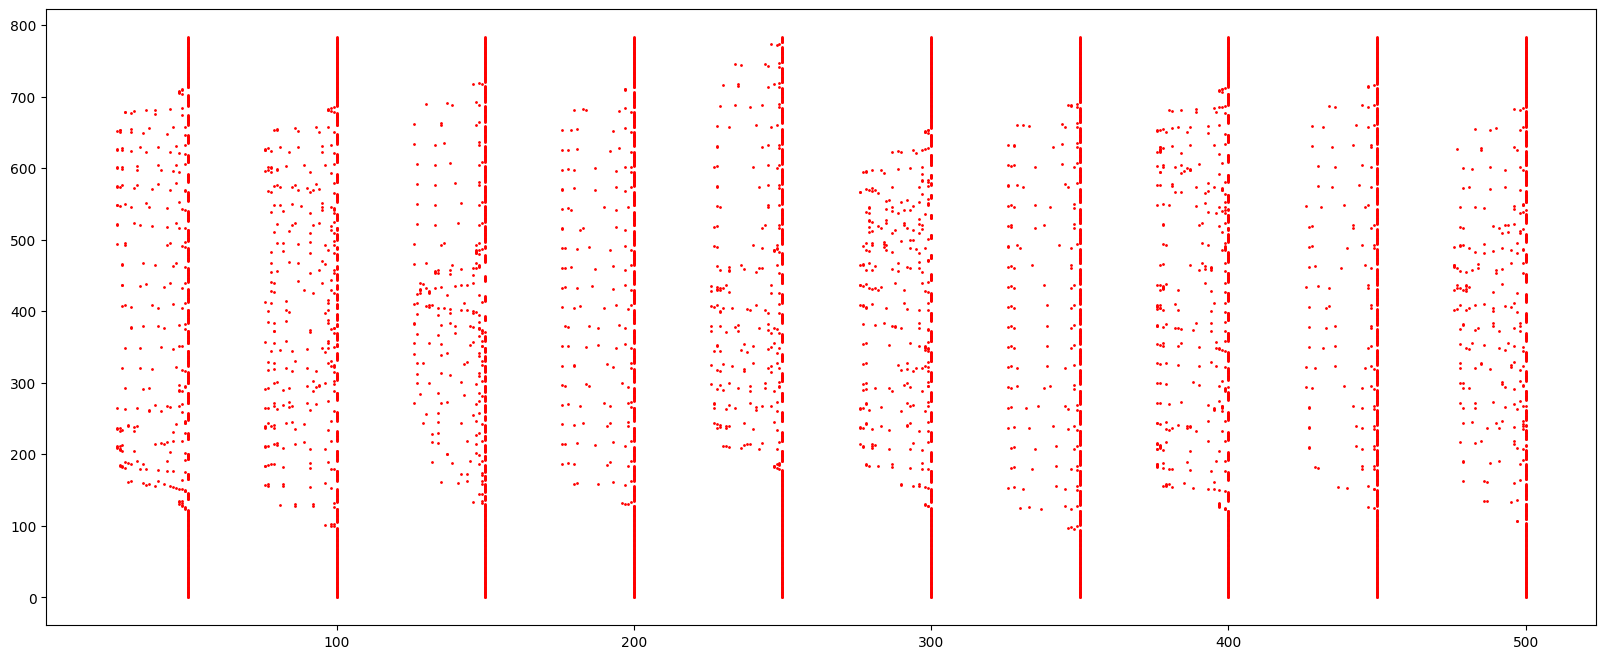

In [20]:
plt.figure(figsize=(20, 8))
plt.scatter(net['ng1_eventrec', 0].variables['spikes'][:, 0].cpu(), net['ng1_eventrec', 0].variables['spikes'][:, 1].cpu(), color='red', s=1)
plt.show()

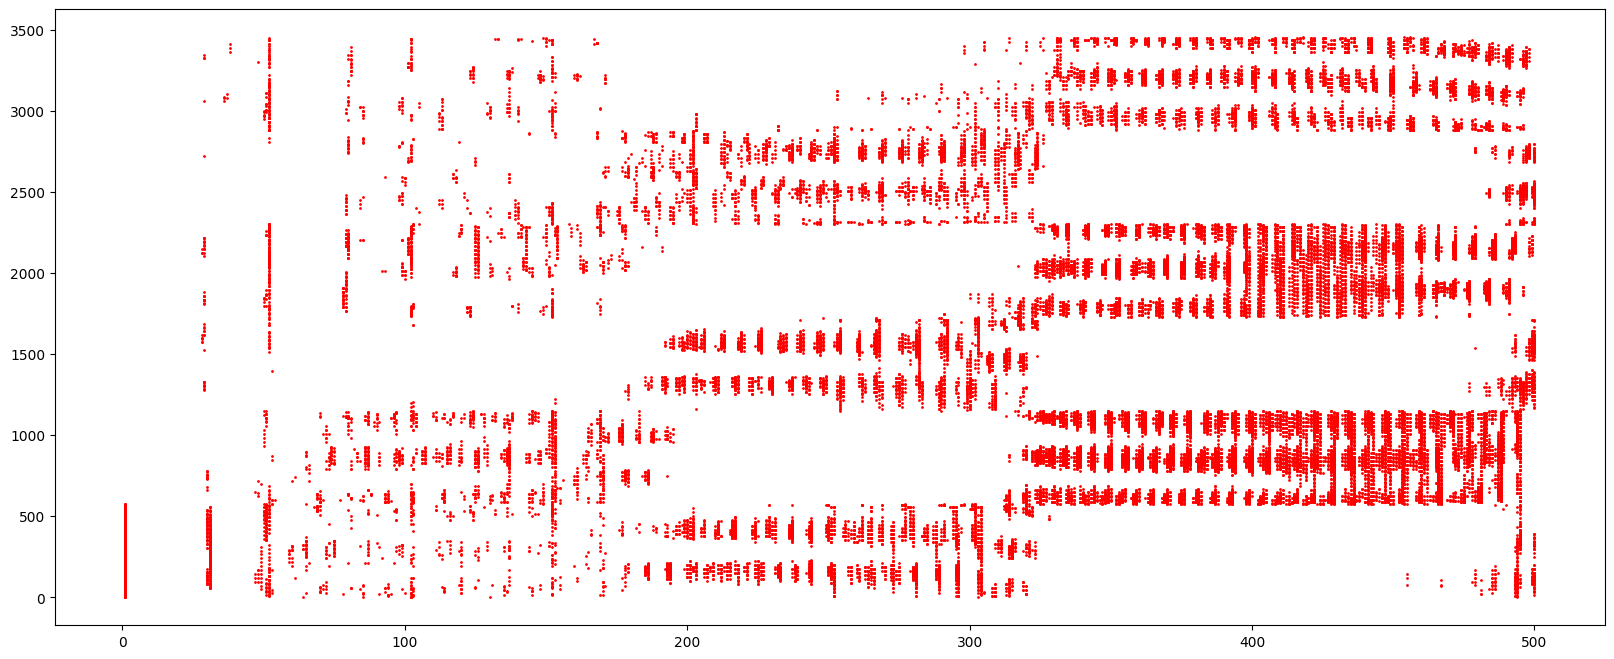

In [21]:
plt.figure(figsize=(20, 8))
plt.scatter(net['ng2_eventrec', 0].variables['spikes'][:, 0].cpu(), net['ng2_eventrec', 0].variables['spikes'][:, 1].cpu(), color='red', s=1)
plt.show()

In [22]:
weights = syn1['weights', 0].cpu()

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_weight_change_heatmaps(weights):
    """
    Plot heatmaps for each feature map showing the magnitude of weight changes at each position.
    
    Args:
    weights (torch.Tensor): Tensor of shape (num_iterations, num_feature_maps, 1, kernel_height, kernel_width)
    """
    num_iterations, num_feature_maps, _, kernel_height, kernel_width = weights.shape
    
    # Calculate total weight change (magnitude) for each position
    weight_changes = np.abs(weights[-1] - weights[0]).squeeze()  # Shape: (num_feature_maps, kernel_height, kernel_width)
    
    # Set up the plot
    fig, axes = plt.subplots(1, num_feature_maps, figsize=(5*num_feature_maps, 5))
    if num_feature_maps == 1:
        axes = [axes]
    
    # Plot heatmap for each feature map
    for feature_map in range(num_feature_maps):
        ax = axes[feature_map]
        
        # Create heatmap
        im = ax.imshow(weight_changes[feature_map], cmap='Blues')
        
        # Add colorbar
        plt.colorbar(im, ax=ax)
        
        # Add labels
        ax.set_title(f'Feature Map {feature_map+1}')
        ax.set_xticks(range(kernel_width))
        ax.set_yticks(range(kernel_height))
        ax.set_xlabel('Width')
        ax.set_ylabel('Height')
        
        # Add text annotations
        for i in range(kernel_height):
            for j in range(kernel_width):
                text = ax.text(j, i, f'{weight_changes[feature_map, i, j]:.2f}',
                               ha="center", va="center", color="w")
    
    plt.suptitle('Magnitude of Weight Changes for Each Feature Map', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


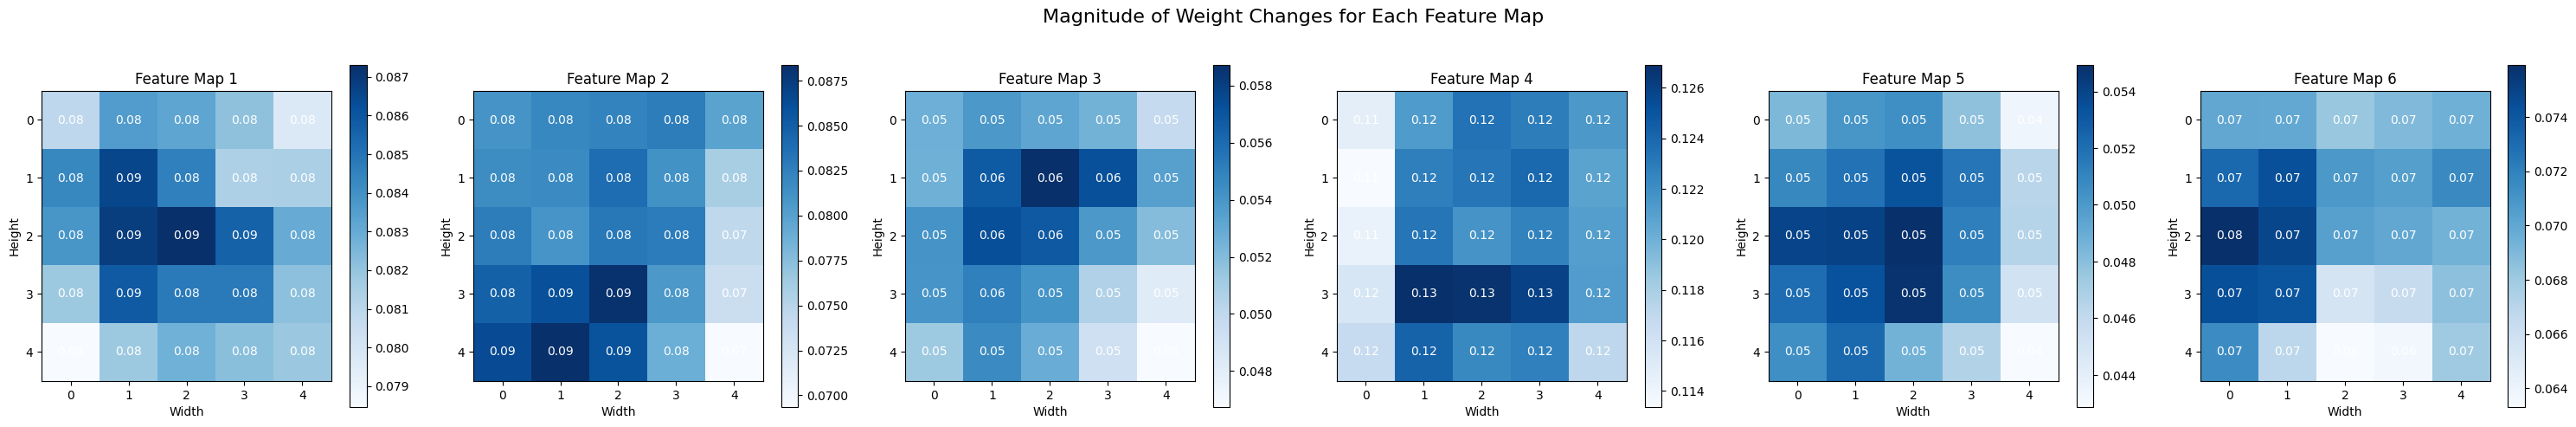

In [24]:
plot_weight_change_heatmaps(weights)

In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_maps(weights, iterations_to_plot, use_mean_threshold=False):
    """
    Plot the weights of each feature map for specified iterations, with optional thresholding based on mean values.
    
    Args:
    weights (torch.Tensor): Tensor of shape (num_iterations, num_feature_maps, 1, kernel_height, kernel_width)
    iterations_to_plot (list): List of iteration indices to plot
    use_mean_threshold (bool): If True, use the mean value of each feature map as its threshold
    """
    num_iterations, num_feature_maps, _, kernel_height, kernel_width = weights.shape
    
    # Ensure all requested iterations are valid
    iterations_to_plot = [i for i in iterations_to_plot if 0 <= i < num_iterations]
    
    if not iterations_to_plot:
        print("No valid iterations to plot.")
        return
    
    # Set up the plot
    fig, axes = plt.subplots(len(iterations_to_plot), num_feature_maps, 
                             figsize=(4*num_feature_maps, 4*len(iterations_to_plot)))
    if len(iterations_to_plot) == 1:
        axes = axes[np.newaxis, :]
    
    # Plot each feature map for each specified iteration
    for row, iteration in enumerate(iterations_to_plot):
        for col in range(num_feature_maps):
            ax = axes[row, col]
            feature_map = weights[iteration, col, 0].detach().cpu().numpy()
            
            if use_mean_threshold:
                # Calculate the mean of the feature map
                threshold = np.mean(feature_map)
                std = np.std(feature_map)
                
                # Apply thresholding
                binary_map = np.where(feature_map >= threshold, 1, 0)
                
                # Plot the binary map
                im = ax.imshow(binary_map, cmap='binary', vmin=0, vmax=1)
                
                # Add text to show the threshold value
                ax.text(0.5, -0.1, f'Threshold: {threshold:.3f}', 
                        horizontalalignment='center', verticalalignment='center', 
                        transform=ax.transAxes, fontsize=8)
            else:
                # Plot the original feature map
                im = ax.imshow(feature_map, cmap='coolwarm')
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            ax.set_xticks([])
            ax.set_yticks([])
            if row == 0:
                ax.set_title(f'Feature {col+1}')
            if col == 0:
                ax.set_ylabel(f'Iteration {iteration}')
    
    plt.tight_layout()
    plt.show()


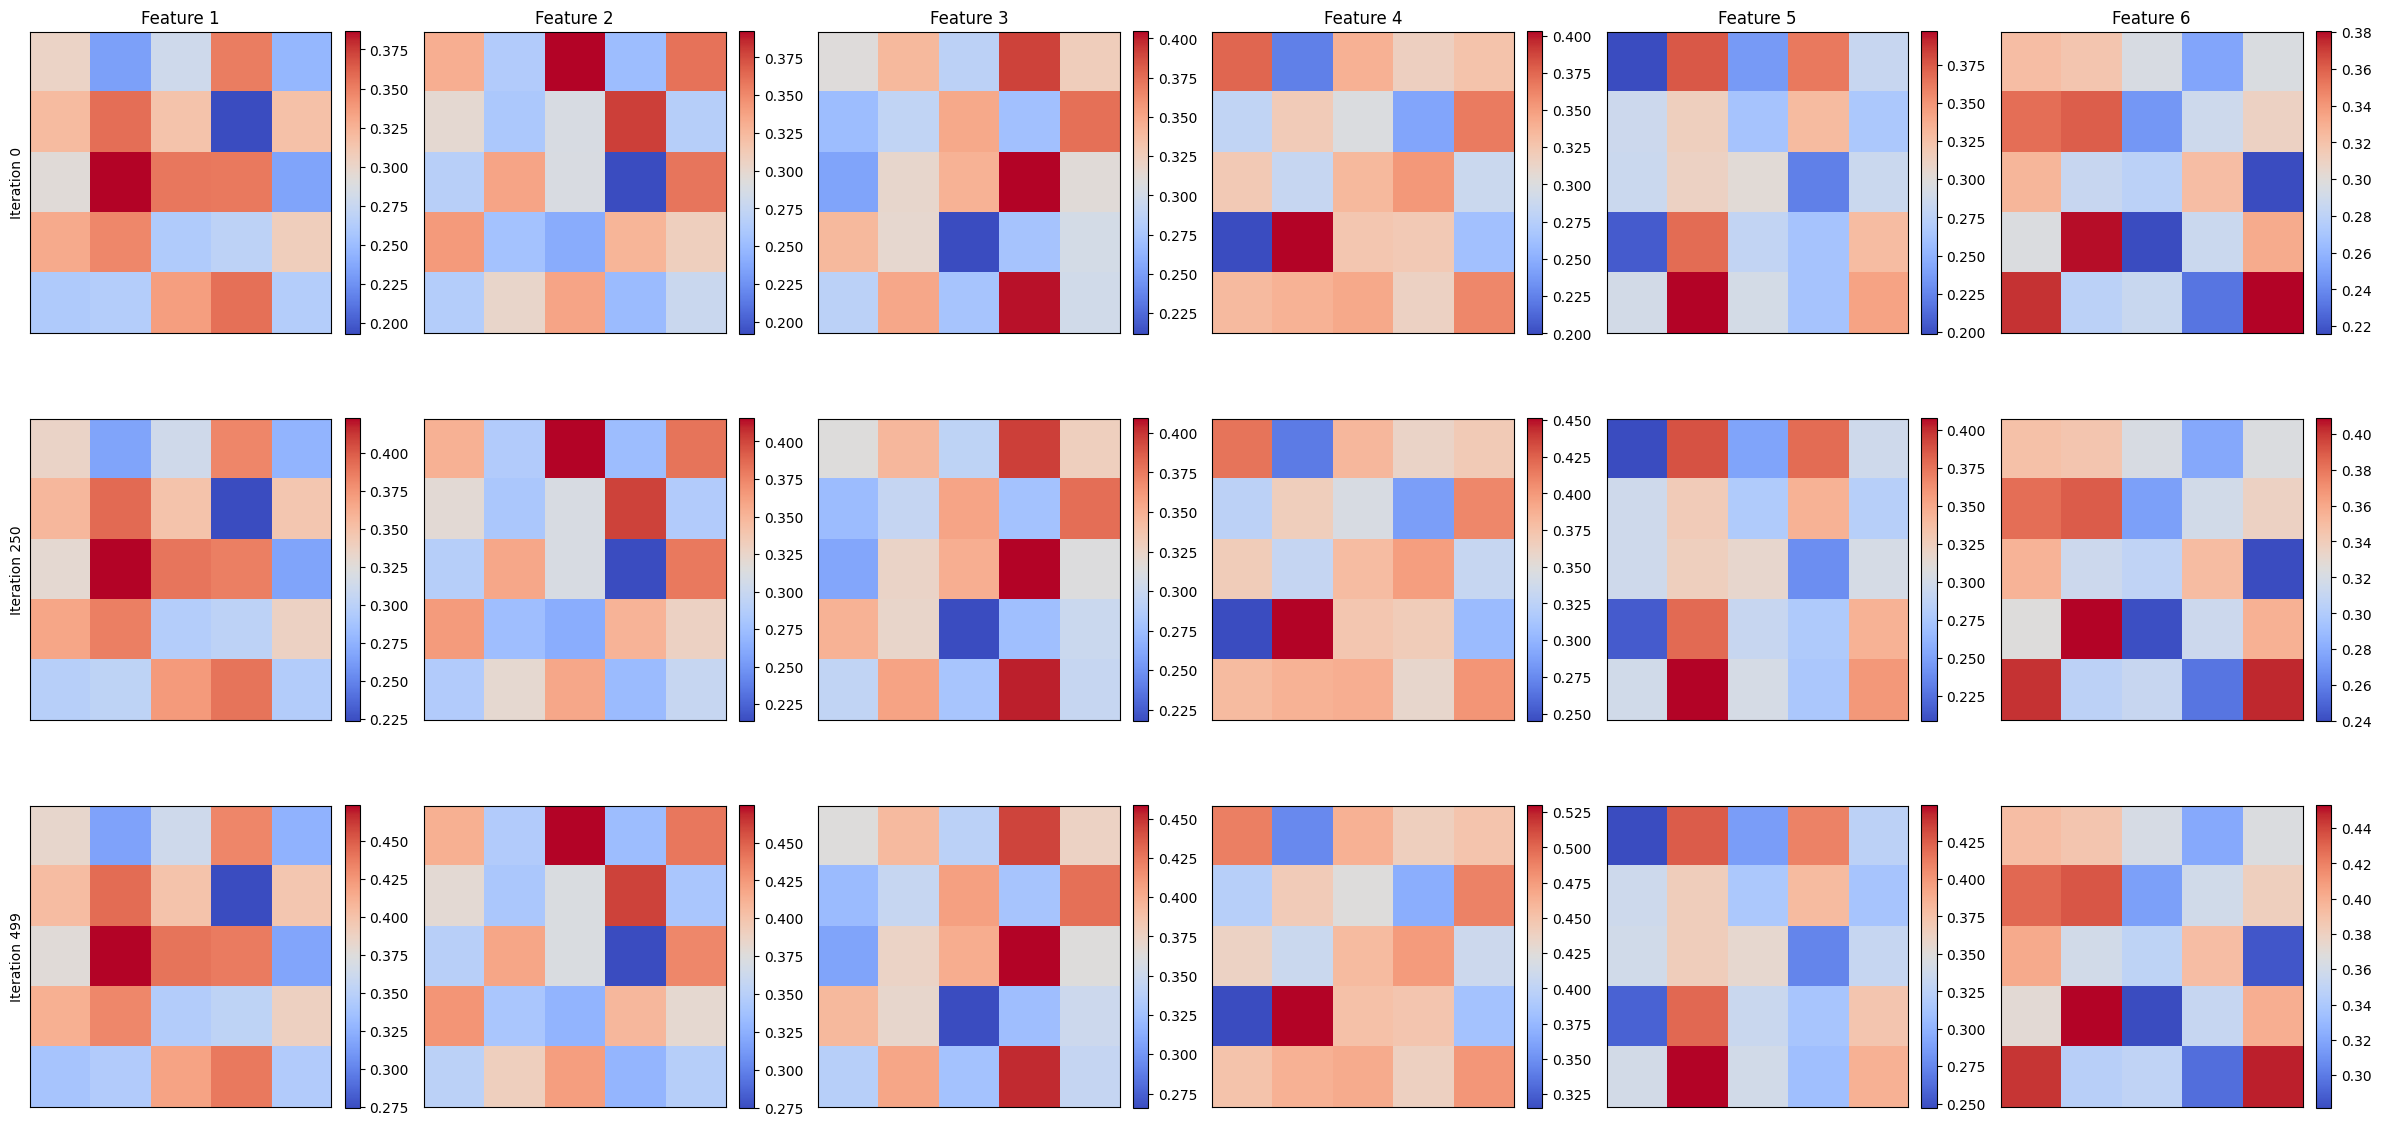

In [26]:

plot_feature_maps(syn1['weights',0].cpu(), [0, ITER//2, ITER-1])

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_weight_changes(weights, figsize=(20, 30)):
    """
    Plot raw weight changes for each feature map over all iterations.
    
    Args:
    - weights: torch.Tensor of shape [iterations, feature_maps, channels, height, width]
    - figsize: tuple, figure size for the entire plot (default: (20, 30))
    """
    num_iterations, num_feature_maps, num_channels, height, width = weights.shape
    
    # Create a figure with subplots for each feature map
    fig, axes = plt.subplots(num_feature_maps, 1, figsize=figsize, sharex=True)
    fig.suptitle("Weight Changes Over Iterations", fontsize=16)
    
    # Create a color map for the weights
    colors = plt.cm.rainbow(np.linspace(0, 1, num_channels * height * width))
    
    for j in range(num_feature_maps):
        ax = axes[j] if num_feature_maps > 1 else axes
        
        # Reshape weights for this feature map
        fm_weights = weights[:, j].reshape(num_iterations, -1)
        
        # Plot each weight
        for k in range(fm_weights.shape[1]):
            ax.plot(range(num_iterations), fm_weights[:, k].cpu().numpy(), 
                    color=colors[k], alpha=0.8, linewidth=0.5)
        
        ax.set_ylabel(f"FM {j+1}")
        ax.grid(True)
        ax.set_ylim(weights.min().item(), weights.max().item())  # Consistent y-axis across all subplots
    
    axes[-1].set_xlabel("Iterations")
    plt.tight_layout()
    plt.show()

weights = syn1['weights', 0].cpu()

# plot_weight_changes(weights)


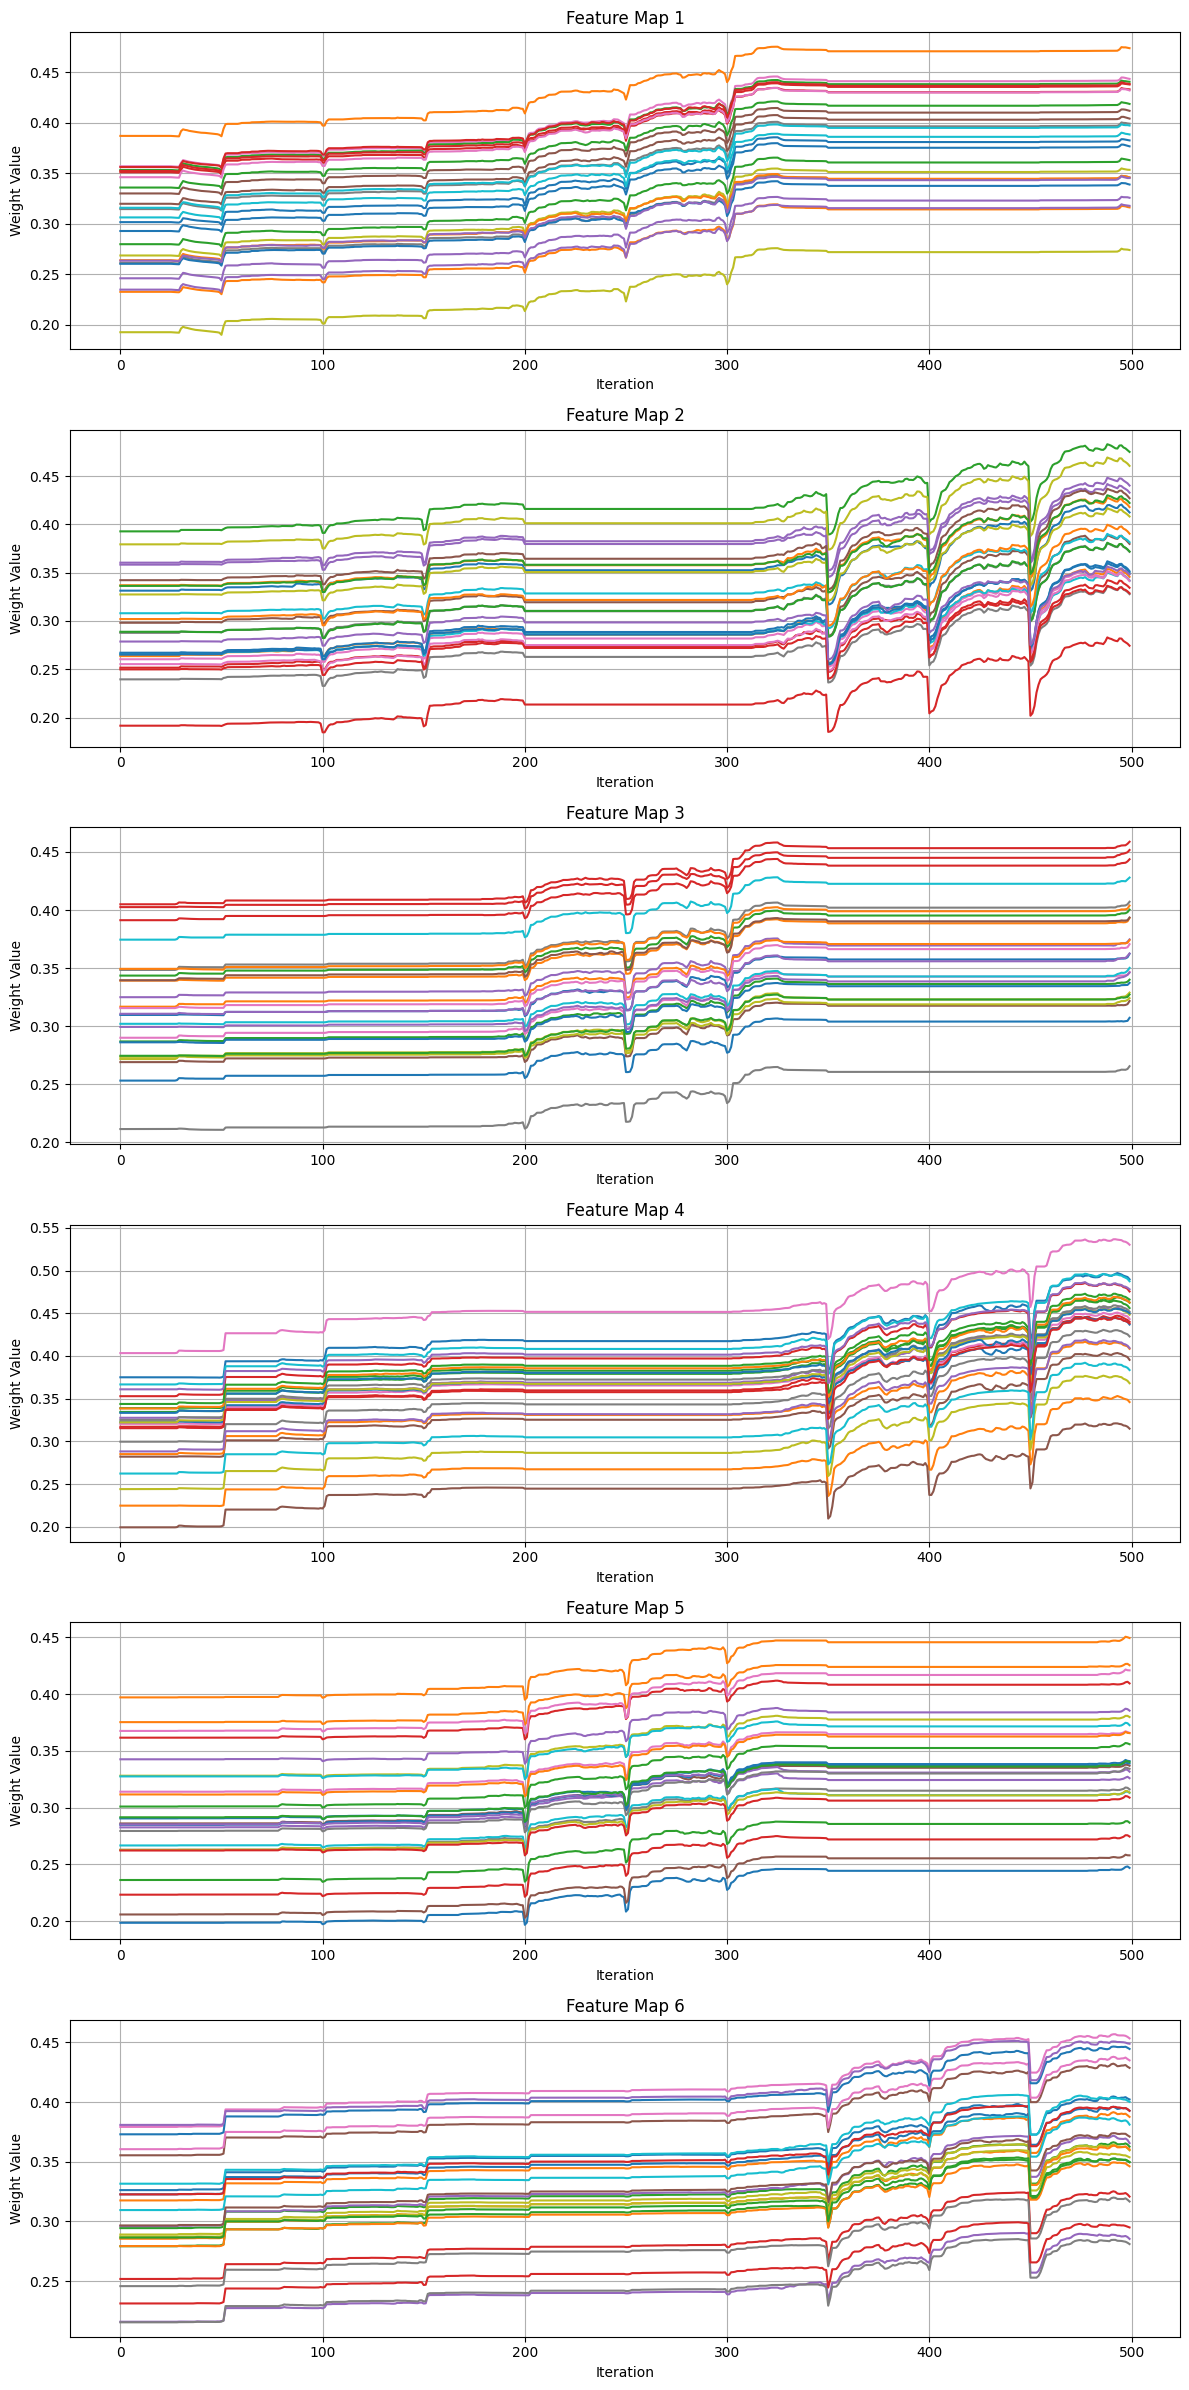

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_weight_evolution(weights):
    """
    Plot the evolution of weights for each feature map over all iterations.
    
    Args:
    weights (torch.Tensor): Tensor of shape (num_iterations, num_feature_maps, 1, kernel_height, kernel_width)
    """
    num_iterations, num_feature_maps, _, kernel_height, kernel_width = weights.shape
    
    # Set up the plot
    fig, axes = plt.subplots(num_feature_maps, 1, figsize=(12, 4*num_feature_maps))
    if num_feature_maps == 1:
        axes = [axes]
    
    # Prepare x-axis (iterations)
    iterations = np.arange(num_iterations)
    
    # Plot weight evolution for each feature map
    for feature_map in range(num_feature_maps):
        ax = axes[feature_map]
        
        # Reshape weights to (num_iterations, kernel_height*kernel_width)
        feature_weights = weights[:, feature_map, 0].reshape(num_iterations, -1)
        
        # Plot each weight
        for i in range(feature_weights.shape[1]):
            ax.plot(iterations, feature_weights[:, i], label=f'Weight {i+1}')
        
        ax.set_title(f'Feature Map {feature_map+1}')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Weight Value')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
plot_weight_evolution(weights)

In [29]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_weights_and_changes(weights):
    """
    Visualize features, overall weight changes, weight changes for each feature map,
    and overall weight distribution before and after training.
    
    Args:
    weights (torch.Tensor): Tensor of shape [iterations, num_features, channels, height, width]
    """
    iterations, num_features, channels, height, width = weights.shape
    
    # 1. Visualize features from the last iteration with separate colorbars
    # fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    # fig.suptitle("Feature Maps in the Last Iteration", fontsize=16)
    
    # for i in range(num_features):
    #     row = i // 3
    #     col = i % 3
    #     ax = axes[row, col]
        
    #     feature_map = weights[-1, i, 0].detach().cpu().numpy()
    #     im = ax.imshow(feature_map, cmap='coolwarm')
    #     ax.set_title(f"Feature Map {i+1}")
    #     ax.axis('off')
        
    #     # Add colorbar for each subplot
    #     plt.colorbar(im, ax=ax)
    
    # plt.tight_layout()
    # plt.show()
    
    # 2. Visualize overall weight changes
    weight_changes = torch.diff(weights, dim=0)
    avg_weight_changes = weight_changes.abs().mean(dim=(1,2,3,4)).cpu().numpy()
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, iterations), avg_weight_changes)
    plt.title("Overall Average Weight Changes Across Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Average Absolute Weight Change")
    plt.grid(True)
    plt.show()
    
    # 3. Visualize weight changes for each feature map
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("Weight Changes for Each Feature Map", fontsize=16)
    
    for i in range(num_features):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        feature_changes = weight_changes[:, i].abs().mean(dim=(1,2,3)).cpu().numpy()
        ax.plot(range(1, iterations), feature_changes)
        ax.set_title(f"Feature Map {i+1}")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Average Absolute Change")
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Visualize weight distribution changes for each feature map
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("Weight Distribution Changes by Feature Map", fontsize=16)
    
    for i in range(num_features):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        initial_weights = weights[0, i].flatten().detach().cpu().numpy()
        final_weights = weights[-1, i].flatten().detach().cpu().numpy()
        
        ax.hist(initial_weights, bins=50, alpha=0.5, label='Initial')
        ax.hist(final_weights, bins=50, alpha=0.5, label='Final')
        ax.set_title(f"Feature Map {i+1}")
        ax.set_xlabel("Weight Value")
        ax.set_ylabel("Frequency")
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 5. Visualize overall weight distribution before and after training
    plt.figure(figsize=(12, 6))
    plt.suptitle("Overall Weight Distribution: Before vs After Training", fontsize=16)
    
    initial_weights = weights[0].flatten().detach().cpu().numpy()
    final_weights = weights[-1].flatten().detach().cpu().numpy()
    
    # Calculate the range for consistent binning
    min_weight = min(initial_weights.min(), final_weights.min())
    max_weight = max(initial_weights.max(), final_weights.max())
    bins = np.linspace(min_weight, max_weight, 100)
    
    plt.hist(initial_weights, bins=bins, alpha=0.5, label='Initial', density=True)
    plt.hist(final_weights, bins=bins, alpha=0.5, label='Final', density=True)
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming 'weights' is your tensor with shape [iterations, 9, 1, height, width]
# visualize_weights_and_changes(weights)

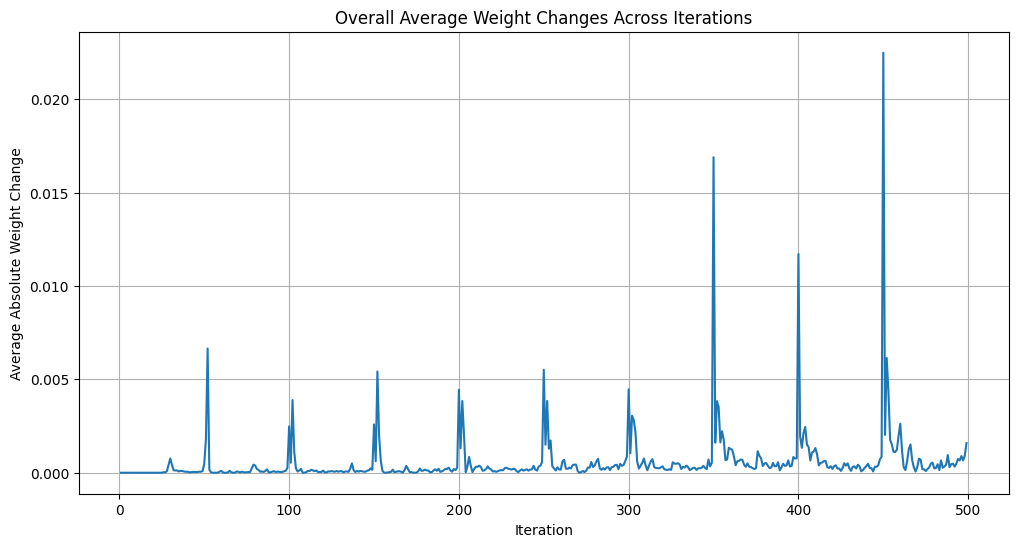

In [30]:
visualize_weights_and_changes(syn1['weights', 0])
